# Online Retail – Customer Segmentation & Sales Analysis

 Dana Nuñez  - May 2025

This notebook explores customer behavior using real transaction data from a UK-based online retailer. The analysis focuses on:

- Cleaning and preparing the dataset  
- Performing RFM (Recency, Frequency, Monetary) analysis  
- Segmenting customers with **K-Means clustering**  
- Visualizing key patterns and profiles  
- Exploring monthly revenue trends with **ARIMA forecasting** (optional practice)

Dataset source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Analizing Raw Data & Cleaning

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load dataset
file_path = '../data/online_retail_raw.xlsx'
df = pd.read_excel(file_path)

# 3. Preview data
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# 4. Quick structure overview
df.info()

# 5. Check for missing values
df.isnull().sum()

# 6. Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# 7. Summary of numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
Number of duplicate rows: 5268


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [3]:
# Check how many duplicated rows exist
print("Duplicated rows before cleaning:", df.duplicated().sum())

# Remove them
df = df.drop_duplicates()

# Confirm removal
print("Duplicated rows after cleaning:", df.duplicated().sum())

Duplicated rows before cleaning: 5268
Duplicated rows after cleaning: 0


In [4]:
# Make a copy of the filtered dataframe to avoid chained assignment issues
quantity_negative = df[df['Quantity'] < 0].copy()

# Ensure InvoiceNo is a string (safe conversion)
quantity_negative['InvoiceNo'] = quantity_negative['InvoiceNo'].astype(str)

# Filter rows where InvoiceNo starts with 'C'
quantity_negative_c = quantity_negative[quantity_negative['InvoiceNo'].str.startswith('C', na=False)]

# Count how many return rows exist
print("Number of returns (InvoiceNo starts with 'C'):", quantity_negative_c.shape[0])

Number of returns (InvoiceNo starts with 'C'): 9251


In [5]:
# Exclude returns: keep only rows with positive quantity and no 'C' in InvoiceNo
df_clean = df[(df['Quantity'] > 0) & (~df['InvoiceNo'].astype(str).str.startswith('C', na=False))]

# Confirm new shape
print("Shape after removing returns:", df_clean.shape)

Shape after removing returns: (526054, 8)


### Excluding Return Transactions

In this dataset, some transactions have negative `Quantity` values, which typically represent product returns. These can be identified by:
- Negative `Quantity` values
- `InvoiceNo` starting with the letter `'C'`

While these are important for operational analysis, they do not reflect actual purchases and can distort Recency, Frequency, and Monetary (RFM) metrics. For the purpose of customer segmentation and sales behavior analysis, we are excluding these rows from our cleaned dataset.

We stored the cleaned version in `df_clean`, which will be used for the next stages of analysis.


In [6]:
# 1. Check how many missing CustomerID values remain
missing_customer_ids = df_clean['CustomerID'].isnull().sum()
print("Missing CustomerID entries:", missing_customer_ids)

# 2. Remove rows with missing CustomerID
df_clean = df_clean[df_clean['CustomerID'].notnull()]

# 3. Confirm new shape
print("Shape after removing missing CustomerID:", df_clean.shape)

Missing CustomerID entries: 133322
Shape after removing missing CustomerID: (392732, 8)


### Removing Missing Customer IDs

In order to perform customer-level analysis, including Recency-Frequency-Monetary (RFM) modeling and customer segmentation, each transaction must be associated with a unique and valid `CustomerID`.

After removing return transactions, we found that some entries still lacked a `CustomerID`. These rows were excluded from further analysis, as they cannot be used for clustering, aggregation, or behavior tracking.

The resulting cleaned dataset (`df_clean`) contains only valid customer transactions and will serve as the base for the next steps of this project.

In [7]:
# Summary statistics after cleaning returns and missing CustomerID
df_clean.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,392732.000000,392732,392732.000000,392732.000000
mean,13.153718,2011-07-10 19:15:24.576301568,3.125596,15287.734822
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,181.588420,NaN,22.240725,1713.567773


### Summary Statistics After Cleaning

After removing returns and entries without CustomerID, we ran `describe()` to better understand the structure and distribution of our cleaned dataset.

Key observations:
- The minimum `Quantity` is now 1, confirming that all return transactions (with negative quantities) have been successfully excluded.
- The `UnitPrice` column shows a minimum value of **0.0**, indicating the presence of transactions where products were registered with no cost. These entries could represent free samples, system errors, or internal tests.
- The standard deviation (`std`) of both `Quantity` and `UnitPrice` has decreased significantly after cleaning. This reflects reduced variability in the data, improving the stability and interpretability of any upcoming clustering or statistical modeling.

These insights help confirm that our cleaning steps are having the intended effect and highlight potential outliers that we may want to address in the next stage.

In [8]:
# Remove transactions where UnitPrice is zero
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Confirm result
print("Shape after removing UnitPrice = 0 rows:", df_clean.shape)

Shape after removing UnitPrice = 0 rows: (392692, 8)


### Removing Zero-Priced Transactions

We identified a number of transactions with a `UnitPrice` of zero. While these entries do not affect the total monetary value of customers directly, they do impact key metrics like:
- **Recency**: as the transaction date is still recorded
- **Frequency**: as the transaction counts toward the customer's total number of purchases

For the purpose of this analysis, which focuses on understanding customer behavior and value through actual purchases, we have chosen to exclude these zero-priced rows. This ensures that our RFM scores and segmentation reflect meaningful transactions only.

## Exploratory Data Analysis (EDA)

Before building any customer segmentation or applying machine learning, we start by exploring the structure and patterns in our cleaned dataset.

The goals of this exploratory analysis are:
- To identify the most popular products based on quantity sold
- To uncover key trends in purchases by country
- To analyze customer behavior and transaction patterns
- To detect potential seasonal or time-based trends
- To visualize the distribution of sales and customers

This step will help us understand the business context, spot outliers, and shape the direction for further analysis and modeling.

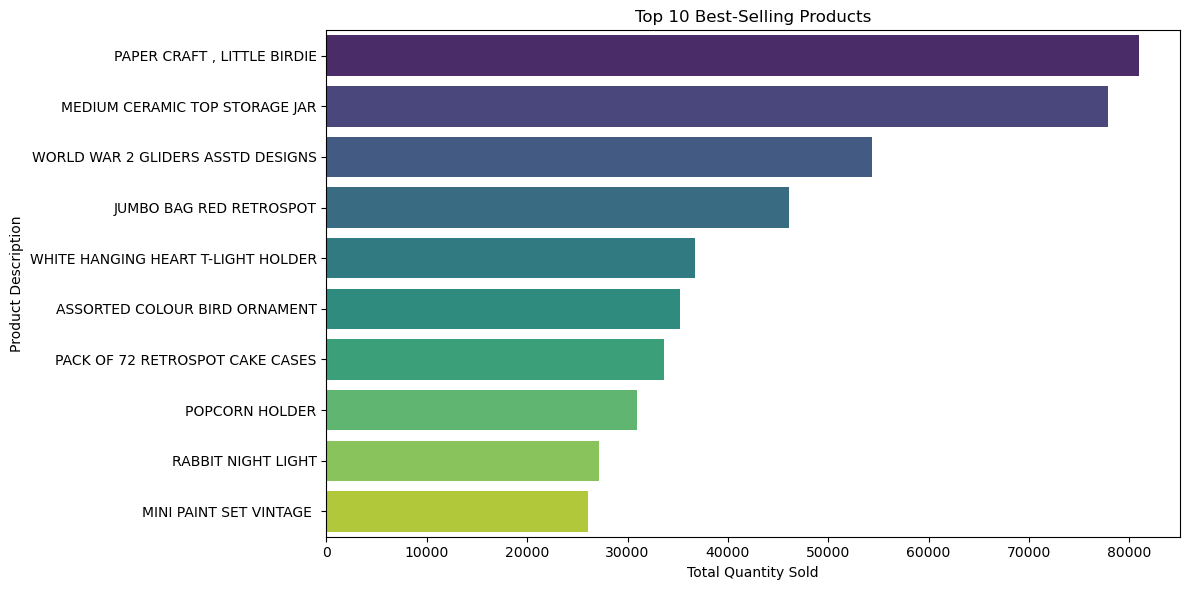

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by product description and sum quantities sold
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

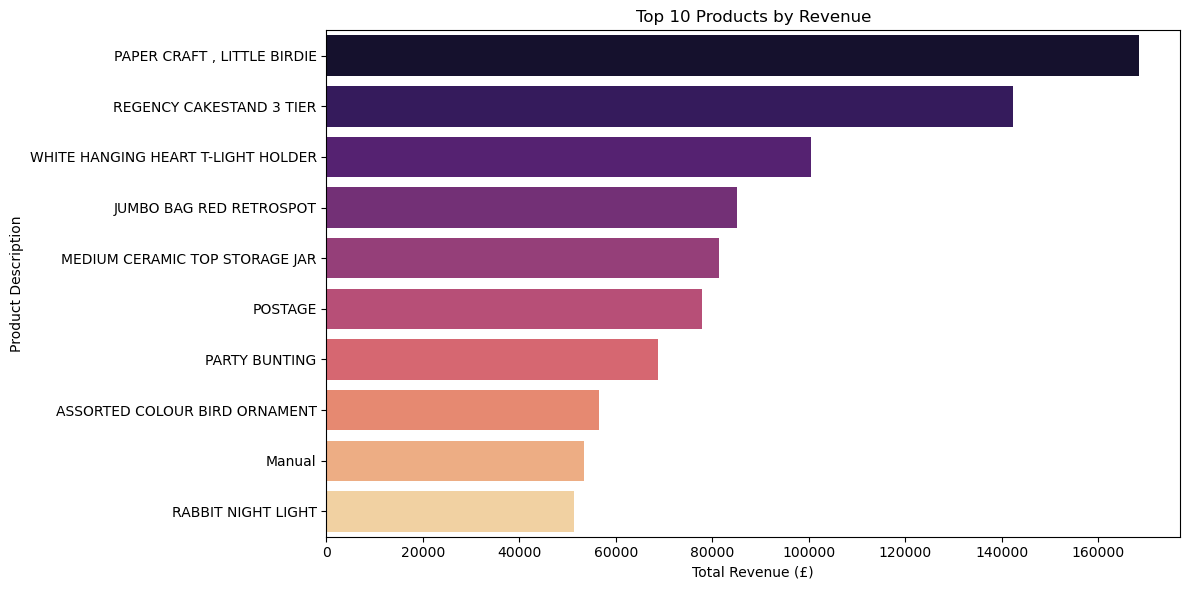

In [11]:
# Crate a new column for revenue
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Group by product and sum revenue 
top_products_revenue = df_clean.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index, palette='magma')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

### Insight: Quantity vs Revenue Leaders

By comparing the top 10 products by quantity sold and by total revenue, we can observe that:

- Several products appear in both lists, indicating that high-volume, low-cost items still contribute significantly to revenue due to their popularity.
- Some products, like "REGENCY CAKESTAND 3 TIER", do not appear in the top sales by quantity, yet rank highly in revenue. These are likely high-ticket items with strong revenue impact per unit.
- The presence of entries like "POSTAGE" and "Manual" in the revenue list suggests possible service or non-product charges, which should be evaluated before clustering or modeling.

This analysis highlights the importance of considering both volume and value when analyzing product performance.

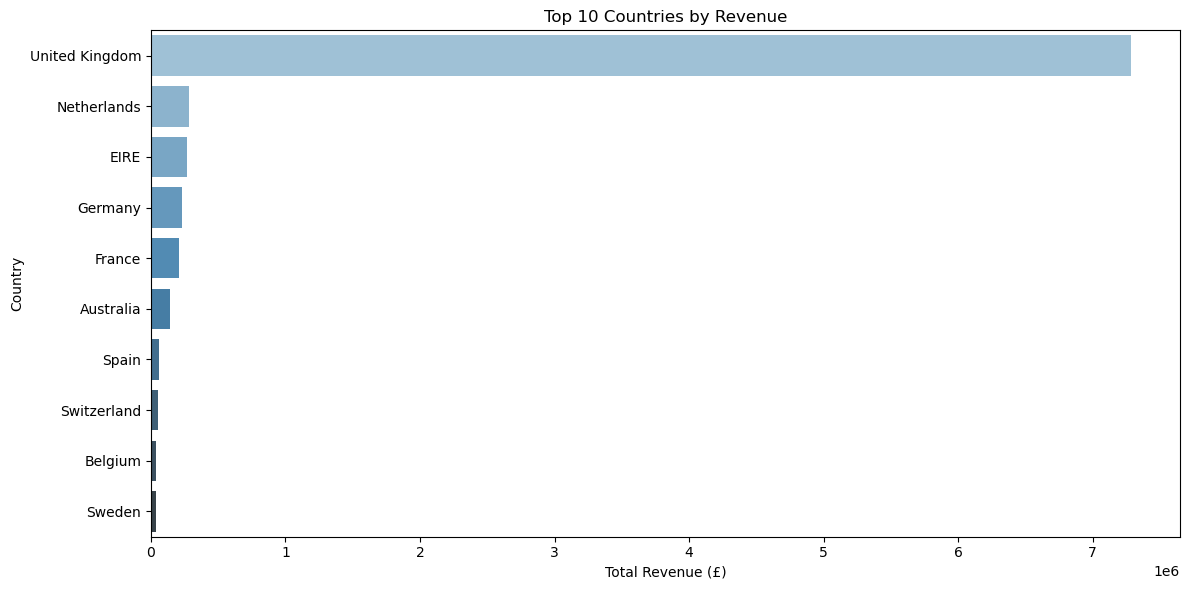

In [15]:
# Revenue by country
revenue_by_country = df_clean.groupby('Country')['Revenue'].sum().sort_values(ascending=False)

# Plot top 10 countries by revenue
plt.figure(figsize=(12,6))
sns.barplot(x=revenue_by_country.values[:10], y=revenue_by_country.index[:10], palette='Blues_d')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue (£)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

### Insight: Revenue by Country

As expected, the United Kingdom dominates the dataset in terms of revenue, accounting for the vast majority of total sales. This is followed by neighboring European countries such as the Netherlands, Ireland (EIRE), Germany, and France.

These findings indicate that the business primarily operates within the UK and Europe, with limited reach to countries like Japan, Singapore, or Australia. While useful to visualize, this country distribution will not be the primary focus of customer-level analysis, but may be considered for future regional segmentation or marketing insights.

## Recency, Frequency & Monetary (RFM) Analysis

In [22]:
# 1. Find the latest date in the dataset
latest_date = df_clean['InvoiceDate'].max()

# 2. Calculate RFM metrics using groupby and aggregation
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'Revenue': 'sum'                                        # Monetary
})

# 3. Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 4. Display the result
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


### Interpreting the RFM Table

From the RFM summary, we can observe that:

- Some customers purchase frequently but spend relatively small amounts, indicating consistent low-ticket behavior.
- Others make fewer purchases, but their total spending is high — representing valuable, though less frequent, buyers.
- The Recency metric also helps us identify how recently each customer made their last purchase. This allows us to distinguish between currently engaged customers and those who may require reactivation strategies.

These patterns are key for prioritizing customer retention efforts and tailoring targeted marketing strategies based on spending behavior and engagement levels.


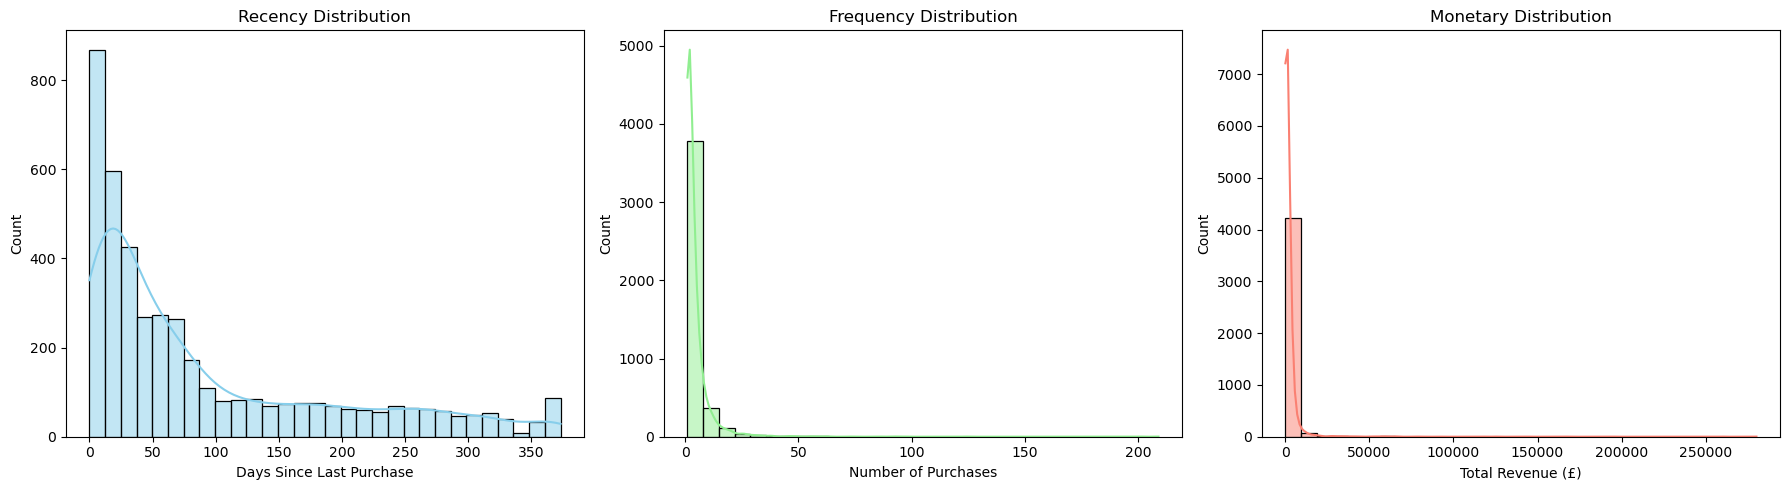

In [24]:
# Set up the plot
plt.figure(figsize=(18,5))

# Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Days Since Last Purchase')

# Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Number of Purchases')

# Monetary
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='salmon')
plt.title('Monetary Distribution')
plt.xlabel('Total Revenue (£)')

plt.tight_layout()
plt.show()

### RFM Metric Distributions

To better understand the behavior of our customers, we visualized the distribution of Recency, Frequency, and Monetary values. Here's what we observed:

- **Recency**: The distribution is left-skewed, with a majority of customers making purchases recently. This indicates strong recent engagement, and suggests that the business has had active customer activity near the end of the data period.

- **Frequency**: Most customers have made between 1 and 15 purchases. This suggests that while the store has a broad customer base, it has relatively few highly loyal or returning customers. Identifying and targeting those with higher frequency could present an opportunity for retention strategies.

- **Monetary**: The vast majority of customers spend relatively small amounts, with a few extreme outliers who have spent significantly more. This indicates a highly unbalanced revenue distribution, which should be considered before applying clustering (e.g., by scaling or transforming the data).

Understanding these patterns will help guide the segmentation process and ensure meaningful clusters are formed.

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler instance
scaler = MinMaxScaler()

# Apply scaler to RFM values
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Preview scaled values
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,0.871314,0.000000,0.275443
12347.0,0.002681,0.028846,0.015368
12348.0,0.198391,0.014423,0.006401
12349.0,0.048257,0.000000,0.006259
12350.0,0.828418,0.000000,0.001180


## Customer Segmentation with K-Means ML

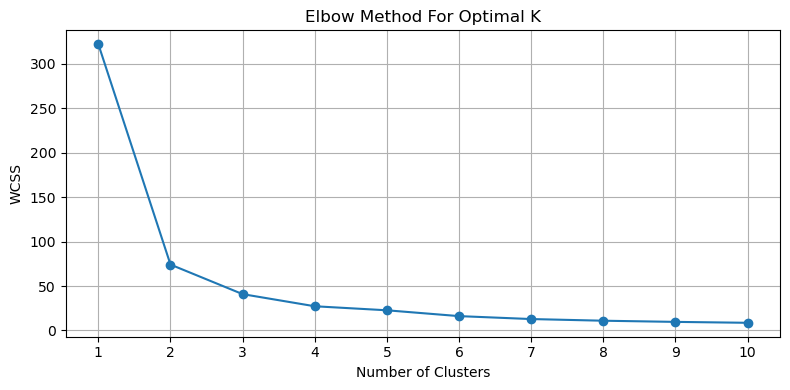

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow Method and Within-Cluster Sum of Squares (WCSS)

# List to store WCSS for each k
wcss = []

# Try K from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Apply K-Means with K=3
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(rfm_scaled)

# Assign cluster labels
rfm['Cluster'] = kmeans.labels_

# Preview the updated RFM with cluster assignments
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,1


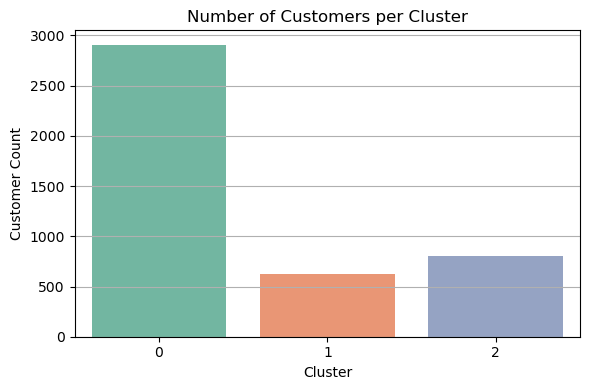

Cluster
0    2906
1     626
2     806
Name: count, dtype: int64

In [57]:
# Countplot of customers in each cluster
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='Cluster', palette='Set2')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customer Count')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Count of customers per cluster
rfm['Cluster'].value_counts().sort_index()

In [31]:
# Mean RFM values per cluster
cluster_profiles = rfm.groupby('Cluster').mean(numeric_only=True)
cluster_profiles

,Recency,Frequency,Monetary
Cluster,,,
0,31.163799,5.470750,2707.342410
1,293.431310,1.354633,605.716166
2,152.400744,2.215881,794.656986


In [56]:
# Define cluster profile labels based on previous interpretation
def label_cluster(row):
    if row['Cluster'] == 0:
        return 'High-Value'
    elif row['Cluster'] == 1:
        return 'Inactive'
    else:
        return 'Potential'

rfm['Cluster_Label'] = rfm.apply(label_cluster, axis=1)

# Create a summary table
profile_summary = rfm.groupby(['Cluster', 'Cluster_Label'])[['Recency', 'Frequency', 'Monetary']].mean().round(1)
profile_summary.reset_index(inplace=True)
profile_summary

,Cluster,Cluster_Label,Recency,Frequency,Monetary
0,0,High-Value,31.2,5.5,2707.3
1,1,Inactive,293.4,1.4,605.7
2,2,Potential,152.4,2.2,794.7


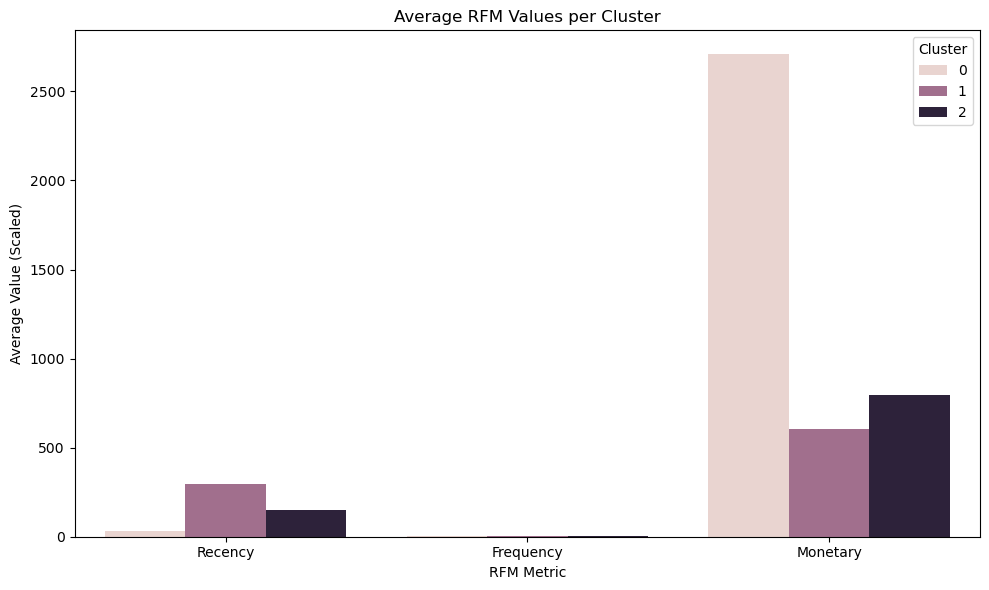

In [32]:
# Reset index for plotting
cluster_profiles = cluster_profiles.reset_index()

# Plot profile comparison
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_profiles.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster')
plt.title('Average RFM Values per Cluster')
plt.xlabel('RFM Metric')
plt.ylabel('Average Value (Scaled)')
plt.tight_layout()
plt.show()

### RFM Cluster Profiles Interpretation

Based on the K-Means clustering (K=3), we identified three distinct customer groups:

- **Cluster 0 (High-Value Customers):**
  - Very low Recency → they purchased recently
  - Very high Monetary → they spend significantly
  - Low Frequency → they don’t buy often, but when they do, the value is high

- **Cluster 1 (Churned or Low-Value Customers):**
  - High Recency → haven’t purchased in a long time
  - Low Frequency and Monetary → minimal overall engagement

- **Cluster 2 (Mid-Tier Customers):**
  - Moderate Recency and spending
  - Lower frequency but potentially recoverable or loyal with incentives

This segmentation allows the business to design tailored strategies for retention, upselling, and reactivation.


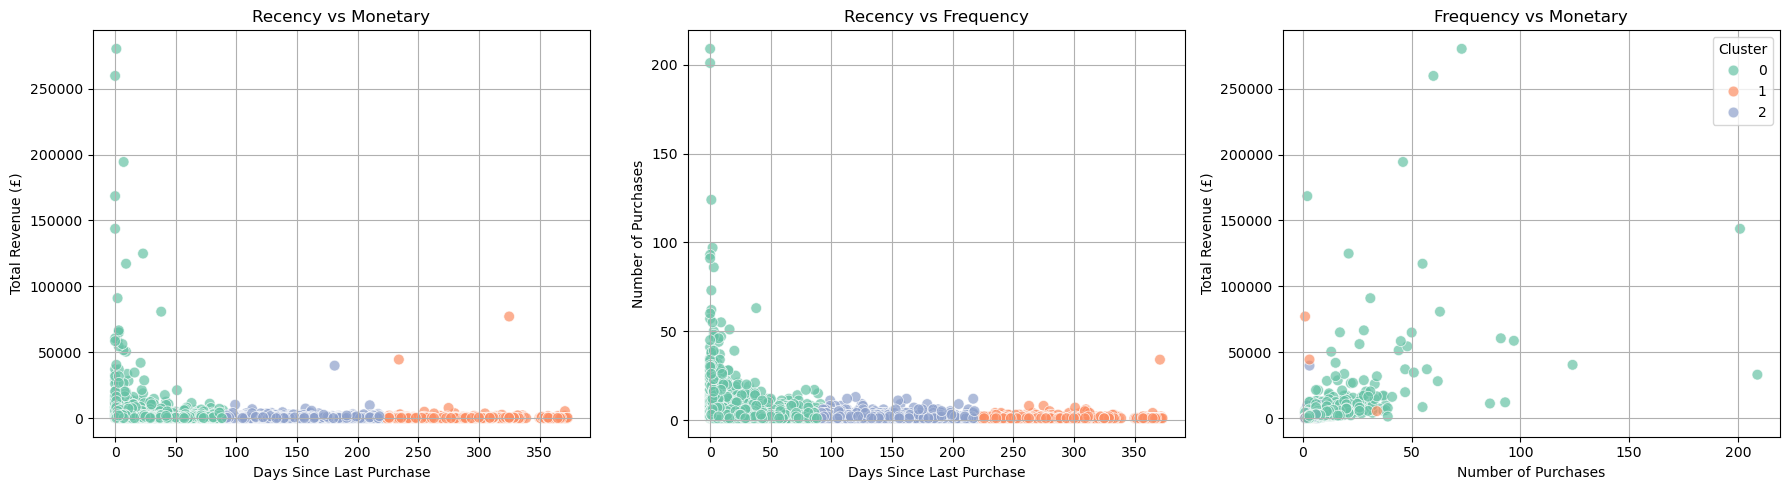

In [44]:
plt.figure(figsize=(18,5))

# 1. Recency vs Monetary
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2', alpha=0.7, s=60)
plt.title('Recency vs Monetary')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Total Revenue (£)')
plt.legend().remove()
plt.grid(True)

# 2. Recency vs Frequency
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2', alpha=0.7, s=60)
plt.title('Recency vs Frequency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Number of Purchases')
plt.legend().remove()
plt.grid(True)

# 3. Frequency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='Set2', alpha=0.7, s=60)
plt.title('Frequency vs Monetary')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Revenue (£)')
plt.legend(title='Cluster')
plt.grid(True)

plt.tight_layout()
plt.show()

### Cluster Visualization: RFM Scatterplots

To better understand the customer segments formed by K-Means, we plotted three key 2D combinations of the RFM metrics:

- **Recency vs Monetary**: Clearly shows that Cluster 0 includes recent and high-value customers, while Cluster 1 contains older, low-value buyers.
- **Recency vs Frequency**: Reinforces the same idea — most Cluster 0 customers are engaged frequently and recently.
- **Frequency vs Monetary**: Displays some overlap between clusters, suggesting that similar purchase frequency can correspond to varying levels of spending.

These visualizations confirm the strength of the segmentation and provide context to design strategies tailored to each group.

### Insight

In this project, we applied **unsupervised machine learning** to segment customers based on their purchasing behavior. Since the dataset does not contain predefined labels (such as "loyal" or "churned" customers), we used clustering to uncover hidden patterns.

We implemented the **K-Means algorithm** on the scaled RFM (Recency, Frequency, Monetary) data to group customers into segments with similar characteristics. After analyzing the Elbow Method, we selected **K = 3** as the optimal number of clusters.

This approach helped us identify:
- High-value, recent buyers (Cluster 0)
- Inactive or low-engagement customers (Cluster 1)
- Mid-tier customers with potential for growth (Cluster 2)

This clustering process is a clear example of **unsupervised learning**, where we allow the model to discover structure in the data without relying on labeled outcomes.

The cluster labels have been added to the final dataset and will be used for business insights, visualization, and future dashboard integration.

In [45]:
# # Export RFM data with assigned clusters
# rfm.to_csv('rfm_clusters.csv')

## Time Series Forecasting (Exploratory Section)

In [46]:
# Convert InvoiceDate to datetime if not already
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create 'Month' column in format YYYY-MM
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M').astype(str)

# Group by month and sum revenue
monthly_revenue = df_clean.groupby('Month')['Revenue'].sum().reset_index()

# Preview
monthly_revenue.head()

,Month,Revenue
0,2010-12,570422.730
1,2011-01,568101.310
2,2011-02,446084.920
3,2011-03,594081.760
4,2011-04,468374.331


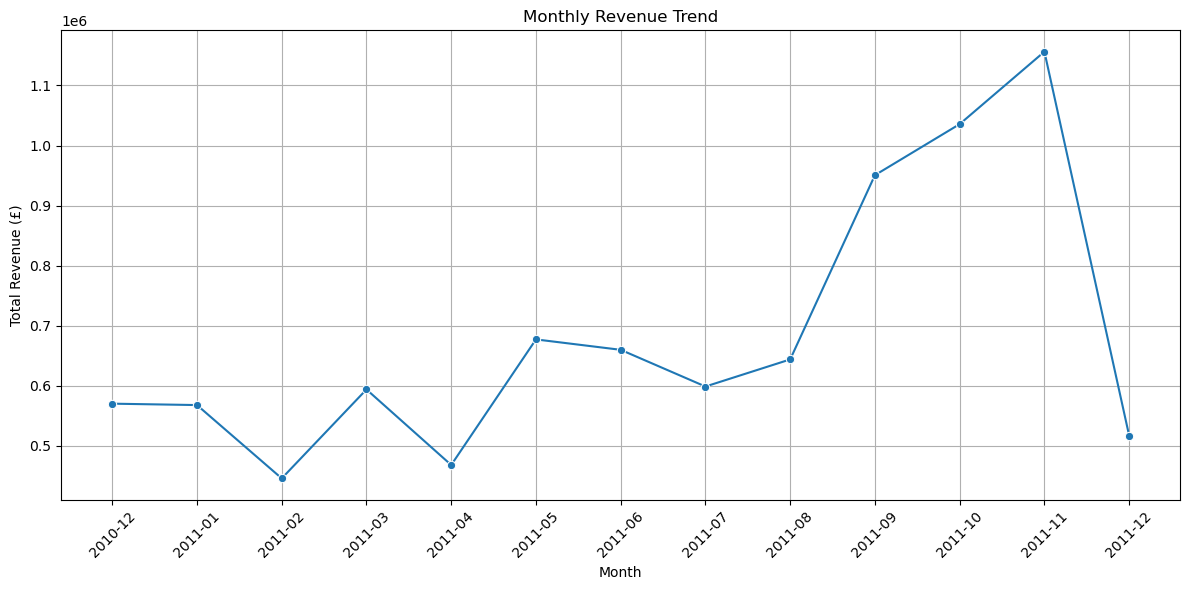

In [47]:
# Plot Tendency 
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_revenue, x='Month', y='Revenue', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Monthly Revenue Trend Analysis

The revenue trend from December 2010 to December 2011 shows a generally increasing pattern, with a sharp rise between August and November 2011. This could be related to seasonal demand toward the end of the year.

However, no consistent month-over-month seasonality is observed throughout the period, indicating that revenue does not follow a repeating annual or monthly cycle. 
The sharp drop in December 2011 is likely due to incomplete data for that month, as the dataset ends mid-December. This should be taken into account when interpreting the trend or forecasting.

In [48]:
# Re-convert Month to datetime format
monthly_revenue['Month'] = pd.to_datetime(monthly_revenue['Month'])

# Set Month as index
monthly_revenue.set_index('Month', inplace=True)

# Check the shape
monthly_revenue.head()

,Revenue
Month,
2010-12-01,570422.730
2011-01-01,568101.310
2011-02-01,446084.920
2011-03-01,594081.760
2011-04-01,468374.331


### ARIMA ML 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')  # To clean up output

# Fit ARIMA model: (p=1, d=1, q=1) as a starting point
model = ARIMA(monthly_revenue['Revenue'], order=(1,1,1))
model_fit = model.fit()

In [52]:
# Forecast 3 future time steps
forecast_steps = 3
forecast = model_fit.forecast(steps=forecast_steps)

# Print forecast
print("Forecast for next 3 months:\n", forecast)

Forecast for next 3 months:
 2012-01-01    637652.844525
2012-02-01    680753.789104
2012-03-01    696175.126832
Freq: MS, Name: predicted_mean, dtype: float64


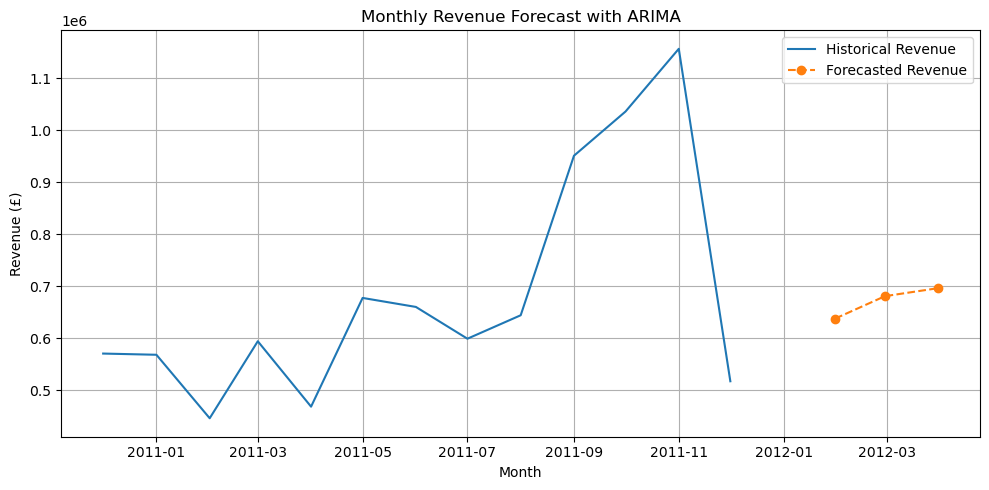

In [53]:
# Plot forecast with historical data
plt.figure(figsize=(10,5))
plt.plot(monthly_revenue.index, monthly_revenue['Revenue'], label='Historical Revenue')
plt.plot(pd.date_range(monthly_revenue.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M'), 
         forecast, label='Forecasted Revenue', marker='o', linestyle='--')
plt.title('Monthly Revenue Forecast with ARIMA')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusion

As a complementary analysis, we explored a simple time series forecasting approach using the ARIMA model. While not central to the project’s customer segmentation goal, this allowed us to practice modeling and interpreting temporal trends.

We used monthly revenue data from December 2010 to December 2011 and applied an ARIMA(1,1,1) model to forecast revenue for the next three months.

**Observations:**
- The forecast shows a slight upward trend for early 2012, consistent with the growth observed in Q4 of 2011.
- The sharp drop in December 2011 is due to incomplete data, not an actual performance decline.
- The model coefficients are not statistically significant, which is expected given the limited number of data points (13 months).
- These results are purely exploratory and should not be considered robust predictions.

This section demonstrates the application of unsupervised learning in tandem with basic forecasting — blending machine learning, temporal analysis, and business insight.


## Final Conclusion

This project successfully demonstrates how customer data can be transformed into actionable insights through data science techniques. Starting from raw transaction records, we cleaned and explored the dataset, then applied **RFM analysis** to quantify customer behavior in terms of:

- **Recency** (How recently a customer purchased)
- **Frequency** (How often they purchased)
- **Monetary** (How much they spent)

Using **K-Means clustering**, we segmented customers into three distinct groups with meaningful profiles:
- **High-Value Customers**
- **Inactive Customers**
- **Potential Customers**

This unsupervised learning approach allowed us to uncover hidden patterns without predefined labels, providing a foundation for targeted marketing, retention, and strategic business decisions.

Additionally, we explored **monthly revenue trends** and implemented a basic **ARIMA forecast** to practice time series modeling.

The insights gained from this project highlight the power of combining analytical thinking with machine learning to enhance customer understanding and drive business value.
